In [1]:
import datashader as ds
import datashader.transfer_functions as tf
import numpy as np
import pandas as pd
from IPython.core.display import HTML, display

In [2]:
data = pd.read_csv('../../data/external/2006 - RENACOM.csv' , encoding = "ISO-8859-1")

In [3]:
data['LONGITUDE']  = pd.to_numeric(data['LONGITUDE'] , errors='coerce')
data['LATITUDE'] = pd.to_numeric(data['LATITUDE'] , errors='coerce')

In [4]:
import pyproj

wgs84=pyproj.Proj("+init=EPSG:4326")
webmercator = pyproj.Proj("+init=EPSG:3857")

data['meterswest'], data['metersnorth'] = pyproj.transform(wgs84, webmercator, list(data['LONGITUDE']) , list(data['LATITUDE']))

In [5]:
fig, extent, datashader_agg = create_base_plot()

hover_layer = HoverLayer(agg=datashader_agg,
                         extent=extent,
                         field_name='N Settlements',
                         how='sum')

fig.renderers.append(hover_layer.renderer)
fig.add_tools(hover_layer.tool)
show(fig)

NameError: name 'create_base_plot' is not defined

In [6]:
display(HTML("<style>.container { width:100% !important; }</style>"))

In [7]:
background = "black"
plot_width  = int(1000)
plot_height = int(plot_width*7.0/12)

Niger = ((20400,  1603000), (1309690, 2403810))
x_range,y_range = Niger

In [8]:
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, viridis, inferno
from IPython.core.display import HTML, display

export = partial(export_image, background = background)
cm = partial(colormap_select, reverse=(background!="black"))

In [9]:
cvs = ds.Canvas(plot_width, plot_height, *Niger)
agg = cvs.points(data, 'meterswest', 'metersnorth')

In [10]:
data.TYPECOM.value_counts()

CR    23561
CU     4747
Name: TYPECOM, dtype: int64

In [11]:
#if background == "black":
#      color_key = {'CR':'aqua', 'VA':'lime',  'CU':'red', 'PE':'fuchsia', 'QT':'yellow' }
#else: color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange',  'o':'saddlebrown'}

if background == "black":
      color_key = {'CR':'aqua',  'CU':'red' }
else: color_key = {'w':'blue', 'b':'green', 'a':'red', 'h':'orange',  'o':'saddlebrown'}

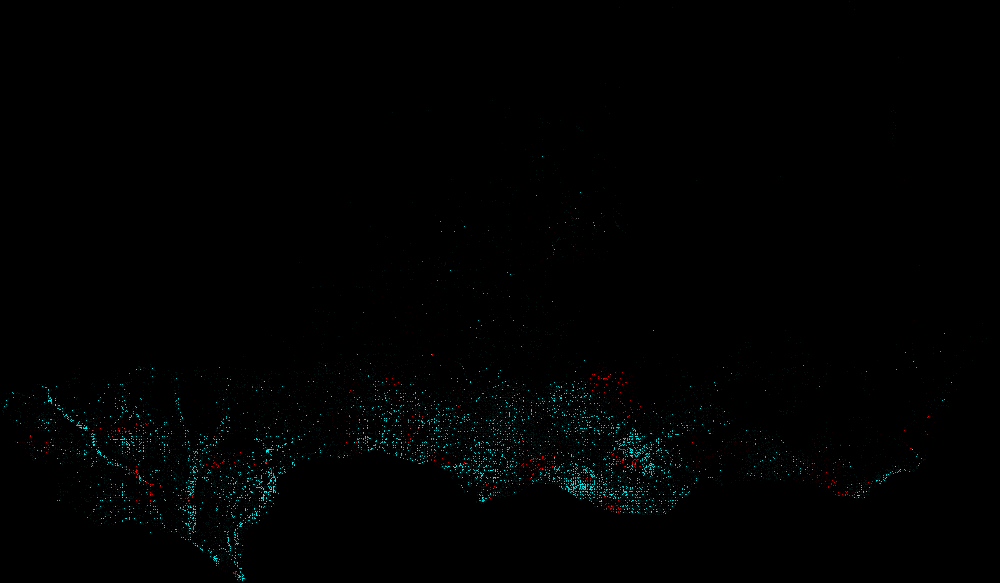

In [12]:
def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data, 'meterswest', 'metersnorth', ds.count_cat('TYPECOM'))
    img = tf.colorize(agg, color_key, how='eq_hist')
    return img

data.TYPECOM = data.TYPECOM.astype('category')

export(create_image(*Niger),"Test")

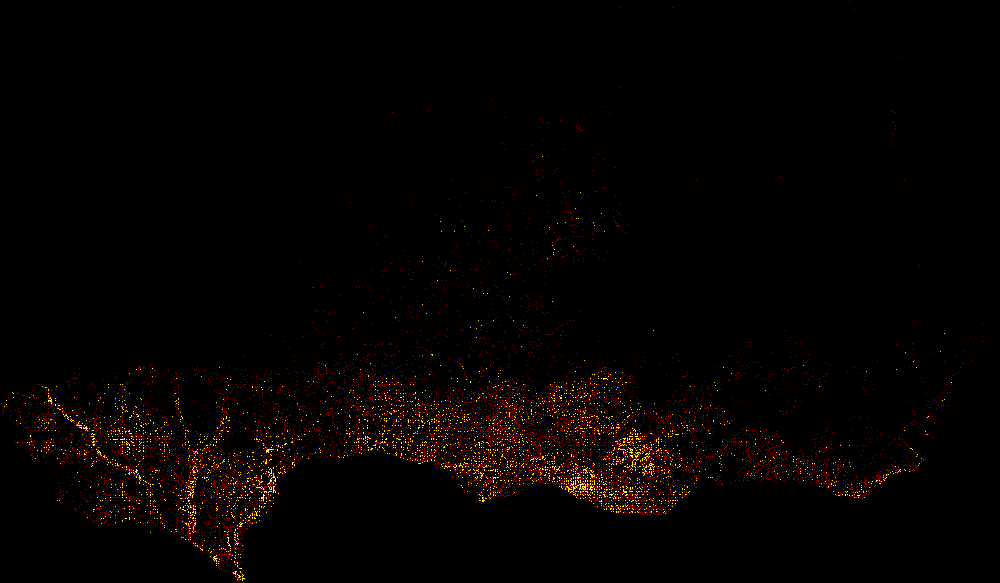

In [13]:
export(tf.interpolate(agg, cmap = cm(Hot,0.2), how='eq_hist'),"census_ds_hot_eq_hist")

In [14]:
from bokeh.models.tiles import WMTSTileSource
from datashader.callbacks import InteractiveImage
from bokeh.plotting import figure, output_file, show, ColumnDataSource, output_notebook
from bokeh.models import HoverTool

output_file('test.html')

def base_plot(tools='pan,wheel_zoom,box_zoom,reset',webgl=False):
    hover = HoverTool( tooltips= [
            ("(x,y)", "($x, $y)"),
            ("name", "@name"),
            ("population", "@population"),
        ])
    p = figure(tools=[tools,hover],
        plot_width=int(900*1.5), plot_height=int(500*1.5),
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0, webgl=webgl)
    
    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    
    return p

In [15]:
x = []
y = [] 
name = [] 
population = []
for u in range(len(data)) :
    x = x + [data.loc[u , 'meterswest']]
    y = y + [data.loc[u , 'metersnorth']]
    name = name + [data.loc[u , 'LOCALITE']]
    population = population + [data.loc[u , 'TOTAL']]

In [16]:
from bokeh.io import output_notebook, show
from bokeh.plotting import Figure

import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf

from datashader.colors import Hot
from datashader.bokeh_ext import HoverLayer

output_file('test.html')

def create_base_plot():
    
    xmin = x_range[0]
    ymin = y_range[0]
    xmax = x_range[1]
    ymax = y_range[1]

    cvs = ds.Canvas(plot_width=900,
                    plot_height=600,
                    x_range=(xmin, xmax),
                    y_range=(ymin, ymax))

    agg = cvs.points(data, 'meterswest', 'metersnorth')
    img = tf.interpolate(agg, cmap=Hot, how='linear')
    fig = Figure(x_range=(xmin, xmax),
                 y_range=(ymin, ymax),
                 plot_width=900,
                 plot_height=600,
                 tools='')
    
    fig.background_fill_color = 'black'
    fig.toolbar_location = None
    fig.axis.visible = False
    fig.grid.grid_line_alpha = 0
    fig.min_border_left = 0
    fig.min_border_right = 0
    fig.min_border_top = 0
    fig.min_border_bottom = 0

    fig.image_rgba(image=[img.data],
                   x=[xmin],
                   y=[ymin],
                   dw=[xmax-xmin],
                   dh=[ymax-ymin])
    return fig, (xmin, ymin, xmax, ymax), agg

fig, extent, datashader_agg = create_base_plot()
show(fig)

In [17]:
from datashader.callbacks import InteractiveImage

def image_callback(x_range, y_range, w, h):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data, 'meterswest', 'metersnorth', ds.count_cat('TYPECOM'))
    img = tf.colorize(agg, color_key, 'log')
    return tf.dynspread(img,threshold=0.75, max_px=8)

p = base_plot()

url="http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{Z}/{Y}/{X}.png"
#url="http://tile.stamen.com/toner-background/{Z}/{X}/{Y}.png"
p.yaxis.major_label_orientation = 'vertical'
tile_renderer = p.add_tile(WMTSTileSource(url=url))
tile_renderer.alpha=1 if background == "black" else 0.15

InteractiveImage(p, image_callback)